# Import Modules

In [3]:
import os
import IPython.display as ipd
from IPython.display import clear_output
from collections import Counter
import soundfile as sf
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal.windows import hamming
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

!pip install librosa
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

Cek Dataset

In [17]:
# Baca metadata
train_df = pd.read_csv('Metadata_Train.csv')

print(f"Jumlah baris metadata Train: {len(train_df)}")

print("\nDistribusi kelas:")
print(train_df['Class'].value_counts())

train_label_dict = dict(zip(train_df['FileName'], train_df['Class']))

# Cek file di folder
train_folder = 'Train_submission'

wav_files_in_train_folder = [f for f in os.listdir(train_folder) if f.endswith('.wav')]

metadata_train_files = set(train_df['FileName'])
folder_train_files = set(wav_files_in_train_folder)

# unlabeled: ada di folder, tapi TIDAK di metadata
unlabeled_train_files = folder_train_files - metadata_train_files

# missing: ada di metadata, tapi TIDAK di folder
missing_train_files = metadata_train_files - folder_train_files

print(f"\nJumlah file di Train folder yang tidak punya label: {len(unlabeled_train_files)}")
print(f"Contoh: {list(unlabeled_train_files)[:2]}")

print(f"\nJumlah file di Train metadata tapi file tidak ada: {len(missing_train_files)}")
print(f"Contoh: {list(missing_train_files)[:2]}")

# Buat list file valid
train_paths = []
train_labels = []
for filename in wav_files_in_train_folder:
    if filename in train_label_dict:
        train_paths.append(os.path.join(train_folder, filename))
        train_labels.append(train_label_dict[filename].lower())

print("\nJumlah data (valid):", len(train_paths))

print("\nDistribusi kelas (valid):")
print(pd.Series(Counter(train_labels)).sort_values(ascending=False))

Jumlah baris metadata Train: 2629

Distribusi kelas:
Class
Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: count, dtype: int64

Jumlah file di Train folder yang tidak punya label: 700
Contoh: ['Va-ord-C7-pp-1c.wav', 'violin_sound (158).wav']

Jumlah file di Train metadata tapi file tidak ada: 1
Contoh: ['029500_morning-rain-piano-65875.wav']

Jumlah data (valid): 1927

Distribusi kelas (valid):
sound_guitar    700
sound_violin    699
sound_piano     528
dtype: int64


Cek Format & Duplikat File

In [19]:
train_df = pd.read_csv('Metadata_Train.csv')

train_folder = 'Train_submission'

# Cek format file di Train
train_wrong_format = [f for f in os.listdir(train_folder) if not f.endswith('.wav')]
print("File di Train dengan format salah:", train_wrong_format)

# Cek duplikat (FileName, Class)
train_dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("\nJumlah baris duplikat persis:", train_dup_rows.sum())

# Cek duplikat FileName saja
train_fname_counts = train_df['FileName'].value_counts()
train_fname_dups = train_fname_counts[train_fname_counts > 1]
print("Jumlah FileName yang duplikat:", len(train_fname_dups))
if not train_fname_dups.empty:
    print(train_fname_dups)

File di Train dengan format salah: []

Jumlah baris duplikat persis: 0
Jumlah FileName yang duplikat: 700
FileName
loop-16247.wav              3
DRUM_SOUND (22).wav         2
DRUM_SOUND (23).wav         2
DRUM_SOUND (24).wav         2
DRUM_SOUND (25).wav         2
                           ..
WaveDrum02_45SD (95).wav    2
WaveDrum02_45SD (96).wav    2
WaveDrum02_45SD (97).wav    2
WaveDrum02_45SD (98).wav    2
WaveDrum02_45SD (99).wav    2
Name: count, Length: 700, dtype: int64


Cek Durasi & Sample Rate Audio

Error reading 029500_morning-rain-piano-65875.wav in Train: [Errno 2] No such file or directory: 'Train_submission\\029500_morning-rain-piano-65875.wav'

Train Dataset
Jumlah file error: 1
Sample rate unik: {24000, 16000, 32000, 48000, 44100}
Durasi min  : 1.06 detik
Durasi max  : 128.06 detik
Durasi mean : 17.9 detik


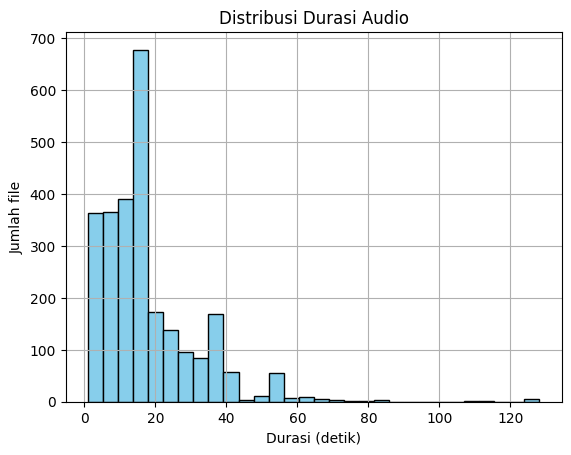

In [21]:
train_df = pd.read_csv('Metadata_Train.csv')

# Cek Train
train_durations = []
train_sr = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('Train_submission', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("\nTrain Dataset")
print("Jumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

    plt.hist(train_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

Visualisasi Dataset Awal

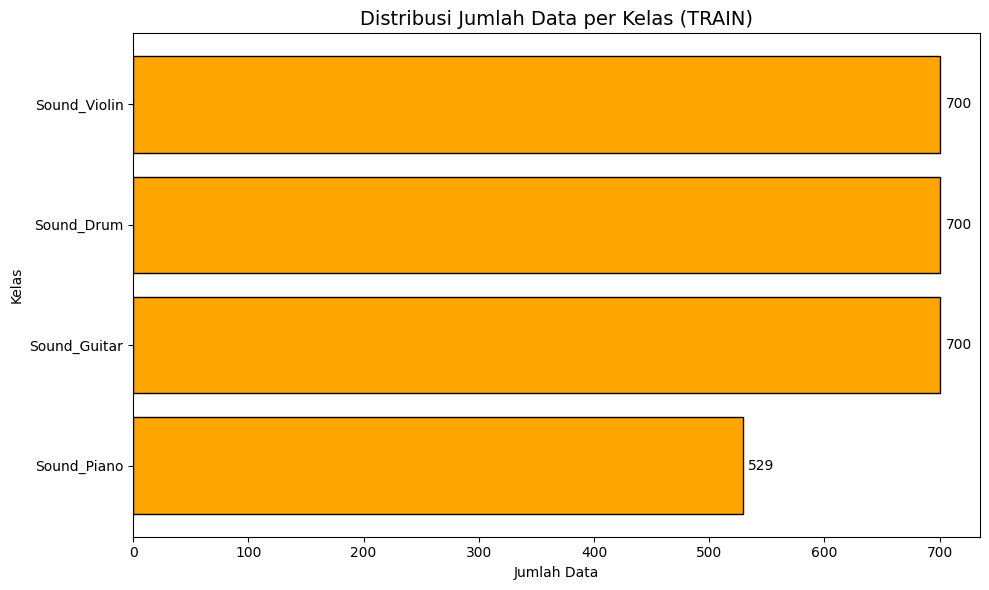

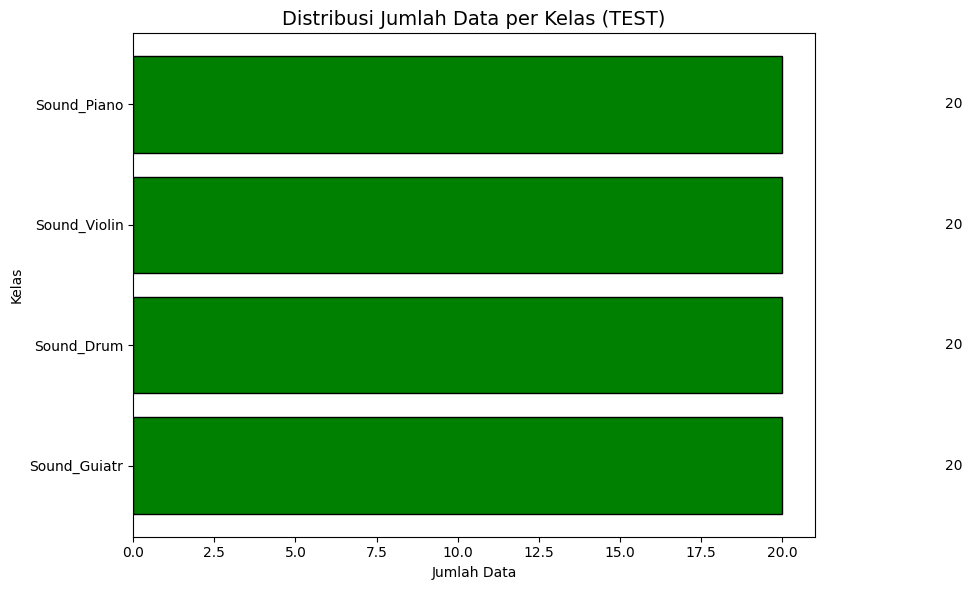

In [251]:
train_df = pd.read_csv('Metadata_Train.csv')

plt.figure(figsize=(10, 6))
bars = plt.barh(train_class_counts.index, train_class_counts.values,
                color='orange', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

# Preprocessing Data Train

 Metadata & File Valid

In [22]:
train_df = pd.read_csv('Metadata_Train.csv')
        
train_folder = 'Train_submission'
clean_folder = 'File_submission_clean'
    
train_label_dict = dict(zip(train_df['FileName'], train_df['Class']))
    
# Ambil file yang valid
clean_train_data = []
for filename in os.listdir(train_folder):
    if filename.endswith('.wav') and filename in train_label_dict:
        clean_train_data.append({
            'file_path': os.path.join(train_folder, filename),
            'filename': filename,
            'label': train_label_dict[filename].lower()
        })
    
print(f"Jumlah file valid: {len(clean_train_data)}")
    
# Distribusi kelas
if clean_train_data:
    train_label_counts = Counter([item['label'] for item in clean_train_data])
    print("\nDistribusi kelas:")
    for label, count in sorted(train_label_counts.items()):
        print(f"  {label}: {count}")
    
# Simpan metadata valid
clean_train_df = pd.DataFrame({
    'FileName': [item['filename'] for item in clean_train_data],
    'Class': [item['label'] for item in clean_train_data]
})
clean_train_df.to_csv('Metadata_Clean.csv', index=False)
print("\nMetadata valid disimpan")
    
# Buat folder baru untuk file valid
if not os.path.exists(clean_folder):
    os.makedirs(clean_folder)
    
for filename in clean_train_df['FileName']:
    src = os.path.join(train_folder, filename)
    dst = os.path.join(clean_folder, filename)
    shutil.copy2(src, dst)
    
print(f"Semua file valid disalin ke folder")

Jumlah file valid: 1927

Distribusi kelas:
  sound_guitar: 700
  sound_piano: 528
  sound_violin: 699

Metadata valid disimpan
Semua file valid disalin ke folder


Cek Format & Duplikasi File

In [23]:
train_df = pd.read_csv('Metadata_Clean.csv')
train_folder = 'File_submission_clean'

# Cek format file di Train & Test
train_wrong_format = [f for f in os.listdir(train_folder) if not f.endswith('.wav')]
print("File dengan format salah:", train_wrong_format)

# Cek duplikat (FileName, Class) di Train
train_dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("\nJumlah baris duplikat persis:", train_dup_rows.sum())

# Cek duplikat FileName saja di Train
train_fname_counts = train_df['FileName'].value_counts()
train_fname_dups = train_fname_counts[train_fname_counts > 1]
print("Jumlah FileName yang duplikat:", len(train_fname_dups))
if not train_fname_dups.empty:
    print(train_fname_dups)

File dengan format salah: []

Jumlah baris duplikat persis: 0
Jumlah FileName yang duplikat: 0


Standarisasi Sample Rate

In [24]:
def standardize_sample_rate(input_folder, output_folder, target_sr=44100):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
    print(f"Jumlah file: {len(files)}")

    for f in files:
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f)

        # Baca audio dan ubah sample rate
        y, sr = librosa.load(input_path, sr=None) 
        if sr != target_sr:
            y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sf.write(output_path, y_resampled, target_sr)
        else:
            # Kalau sample rate sudah sama, tetap salin
            sf.write(output_path, y, sr)

    print("\nSemua file sudah distandarisasi ke {} Hz & disimpan di: {}".format(target_sr, output_folder))

standardize_sample_rate(
    input_folder='File_submission_clean',
    output_folder='File_submission_44100Hz',
    target_sr=44100
)

Jumlah file: 1927

Semua file sudah distandarisasi ke 44100 Hz & disimpan di: File_submission_44100Hz


Filter Durasi

In [25]:
def standardize_duration(input_folder, output_folder, target_sr=44100, target_duration=3.0):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
    print(f"Jumlah file: {len(files)}")

    target_length = int(target_sr * target_duration)

    for f in files:
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f)

        try:
            y, sr = librosa.load(input_path, sr=target_sr)

            original_len = len(y)

            if original_len < target_length:
                # Pad dengan zero di tengah
                pad_length = target_length - original_len
                pad_before = pad_length // 2
                pad_after = pad_length - pad_before
                y = np.pad(y, (pad_before, pad_after), mode='constant')
                action = f"padded ({len(y)/sr:.2f}s)"

            elif original_len > target_length:
                # Ambil bagian tengah
                start = (original_len - target_length) // 2
                end = start + target_length
                y = y[start:end]
                action = f"cropped middle ({len(y)/sr:.2f}s)"

            else:
                action = "unchanged"

            # Simpan file hasil standarisasi
            sf.write(output_path, y, target_sr)

        except Exception as e:
            print(f"Error processing {f}: {e}")
            continue

    print(f"\nSemua file distandarisasi ke {target_duration} detik dan disimpan di: {output_folder}")

standardize_duration(
    input_folder='File_submission_44100Hz',
    output_folder='File_submission_44100Hz_3s',
    target_sr=44100,
    target_duration=3.0
)

Jumlah file: 1927

Semua file distandarisasi ke 3.0 detik dan disimpan di: File_submission_44100Hz_3s


Normalisasi Audio

In [28]:
AUDIO_DIR = 'File_submission_44100Hz_3s'
OUTPUT_DIR = 'File_submission_fixed'
EXPECTED_DURATION = 3.0
SILENCE_THRESHOLD = 0.001 
instrument = ''
target_db = -20.0

# Buat folder output
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Fungsi normalisasi
def normalize_audio(input_path, output_path, target_db=-20.0):
    y, sr = librosa.load(input_path, sr=None)
    rms = np.sqrt(np.mean(y**2))
    current_db = 20 * np.log10(rms + 1e-6)
    gain_db = target_db - current_db
    gain = 10 ** (gain_db / 20)
    y_boosted = y * gain
    max_val = np.max(np.abs(y_boosted))
    if max_val > 1:
        y_boosted = y_boosted / max_val
    sf.write(output_path, y_boosted, sr)
    print(f"Dinormalisasi: {os.path.basename(output_path)}")

df = pd.read_csv('Metadata_Clean.csv')

# Filter berdasarkan instrumen
filtered = df[df['Class'].str.lower().str.startswith(instrument.lower())]

# Simpan file
to_normalize = []

# Loop semua file
for idx, row in filtered.iterrows():
    file_name = row['FileName']
    full_path = os.path.join(AUDIO_DIR, file_name)
    output_path = os.path.join(OUTPUT_DIR, file_name)

    try:
        y, sr = librosa.load(full_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)

        # Deteksi anomali
        is_anomaly = False
        if duration < EXPECTED_DURATION:
            print(f"- {file_name}: Durasi kurang")

        rms = np.sqrt(np.mean(y ** 2))
        if rms < SILENCE_THRESHOLD:
            print(f"- {file_name}: Terlalu sunyi / tidak ada suara")
            is_anomaly = True

        spec = np.abs(librosa.stft(y))
        spectral_flatness = librosa.feature.spectral_flatness(S=spec)
        if np.mean(spectral_flatness) > 1.0:
            print(f"- {file_name}: Spektrum terlalu flat (mungkin noise)")

        # Simpan hasil
        if is_anomaly:
            normalize_audio(full_path, output_path, target_db)
        else:
            shutil.copy2(full_path, output_path)
            print(f"Disalin tanpa perubahan: {file_name}")

    except Exception as e:
        print(f"Error memproses {file_name}: {str(e)}")

print("\nSemua file telah diproses dan disalin ke folder output.")

Disalin tanpa perubahan: 035568_upright-piano-71570.wav
Disalin tanpa perubahan: 04-47367.wav
Disalin tanpa perubahan: 046578_tribal-drum-rhythms-03wav-68096.wav
Disalin tanpa perubahan: 054399_8039s-old-school-rap-drum-loop-80433.wav
Disalin tanpa perubahan: 056514_drum-40118.wav
Disalin tanpa perubahan: 059960_sonido2-sincopa-alta-7mp3-47316.wav
Disalin tanpa perubahan: 060311_rubbing-drum-sticksaif-82905.wav
Disalin tanpa perubahan: 065339_metal-bass-drum-90850.wav
Disalin tanpa perubahan: 066166_qui-c39est-qu39est-tombe-loop-t85wav-39366.wav
Disalin tanpa perubahan: 068320_hang-drum-2wav-80568.wav
Disalin tanpa perubahan: 1-E1-Major 00.wav
Disalin tanpa perubahan: 1-E1-Major 01.wav
Disalin tanpa perubahan: 1-E1-Major 02.wav
Disalin tanpa perubahan: 1-E1-Major 03.wav
Disalin tanpa perubahan: 1-E1-Major 04.wav
Disalin tanpa perubahan: 1-E1-Major 05.wav
Disalin tanpa perubahan: 1-E1-Major 06.wav
Disalin tanpa perubahan: 1-E1-Major 07.wav
Disalin tanpa perubahan: 1-E1-Major 08.wav
Disa

Cek Sample Rate, Durasi, & Outlier File

In [29]:
train_df = pd.read_csv('Metadata_Clean.csv')

# Cek Train
train_durations = []
train_sr = []
train_files = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('File_submission_fixed', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
        train_files.append(fn)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("Dataset")
print("Jumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

Dataset
Jumlah file error: 0
Sample rate unik: {44100}
Durasi min  : 3.0 detik
Durasi max  : 3.0 detik
Durasi mean : 3.0 detik


# Augmentasi Data

In [30]:
def augment_to_target_count(
    input_folder,
    metadata_csv,
    output_folder,
    target_sr=44100,
    target_duration=3.0,
    target_count=700,
    pitch_steps=[-2, -1, 1, 2],
    metadata_output_csv='Metadata_Augmented.csv'
):

# Augmentasi piano & violin hingga jumlahnya sama dengan target_count, hanya menggunakan pitch shift.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Baca metadata
    df = pd.read_csv(metadata_csv)
    label_dict = dict(zip(df['FileName'], df['Class']))

    new_metadata = []

    # Hitung jumlah per kelas
    class_counts = df['Class'].value_counts().to_dict()
    print("Jumlah per kelas saat ini:")
    for cls, cnt in class_counts.items():
        print(f"  {cls}: {cnt}")

    # Pilih kelas yang mau diseimbangkan
    classes_to_balance = ['sound_guitar', 'sound_piano', 'sound_violin']

    for cls in classes_to_balance:
        files = [f for f in os.listdir(input_folder)
                 if f.endswith('.wav') and label_dict.get(f).lower() == cls]

        current_count = len(files)
        needed = target_count - current_count

        print(f"\nKelas {cls}: {current_count} file, butuh augmentasi {needed} file untuk capai {target_count}")

        if needed <= 0:
            print(f"  ✓ Kelas {cls} sudah cukup")
            needed = 0

        # Salin file asli dulu & catat ke metadata baru
        for f in files:
            src = os.path.join(input_folder, f)
            dst = os.path.join(output_folder, f)
            y, sr = librosa.load(src, sr=target_sr)

            # Pastikan durasi sesuai
            target_len = int(sr * target_duration)
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)))
            else:
                y = y[:target_len]

            sf.write(dst, y, sr)
            new_metadata.append({'FileName': f, 'Class': cls})

        # Augmentasi acak dari file asli
        augmented = 0
        while augmented < needed:
            f = random.choice(files)
            y, sr = librosa.load(os.path.join(input_folder, f), sr=target_sr)

            steps = random.choice(pitch_steps)
            y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
            suffix = f"_ps{steps:+}"

            # Pad/crop ke durasi target
            target_len = int(sr * target_duration)
            if len(y_aug) < target_len:
                y_aug = np.pad(y_aug, (0, target_len - len(y_aug)))
            else:
                y_aug = y_aug[:target_len]

            # Nama file baru
            new_name = f.replace('.wav', f'_aug{augmented}{suffix}.wav')
            sf.write(os.path.join(output_folder, new_name), y_aug, sr)

            new_metadata.append({'FileName': new_name, 'Class': cls})
            augmented += 1
            print(f"  ✓ {new_name} dibuat (pitch shift {steps:+} semitone)")

    print(f"\nAugmentasi selesai file disimpan di: {output_folder}")

    # Simpan metadata baru
    new_metadata_df = pd.DataFrame(new_metadata)
    new_metadata_df.to_csv(metadata_output_csv, index=False)
    print(f"Metadata final disimpan: {metadata_output_csv}")

augment_to_target_count(
    input_folder='File_submission_44100Hz_3s',
    metadata_csv='Metadata_Clean.csv',
    output_folder='File_submission_final',
    target_sr=44100,
    target_duration=3.0,
    target_count=700,
    pitch_steps=[-2, -1, 1, 2],
    metadata_output_csv='Metadata_Augmented.csv'
)

Jumlah per kelas saat ini:
  sound_guitar: 700
  sound_violin: 699
  sound_piano: 528

Kelas sound_guitar: 700 file, butuh augmentasi 0 file untuk capai 700
  ✓ Kelas sound_guitar sudah cukup

Kelas sound_piano: 528 file, butuh augmentasi 172 file untuk capai 700
  ✓ ROOM_room7_MUS_scale_DEV_iphone_aug0_ps-2.wav dibuat (pitch shift -2 semitone)
  ✓ ROOM_room7_MUS_joplin_DEV_ipad_aug1_ps-1.wav dibuat (pitch shift -1 semitone)
  ✓ ROOM_room1_MUS_scale_DEV_stereomic_aug2_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ ghost-scare-vintage-6062_aug3_ps-2.wav dibuat (pitch shift -2 semitone)
  ✓ ROOM_room2_MUS_swing_DEV_stereomic_aug4_ps-1.wav dibuat (pitch shift -1 semitone)
  ✓ ROOM_room8_MUS_bartok_DEV_lg_aug5_ps-2.wav dibuat (pitch shift -2 semitone)
  ✓ ROOM_room7_MUS_mozart_DEV_ipad_aug6_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ ROOM_room4_MUS_beethoven2_DEV_amazon_aug7_ps+1.wav dibuat (pitch shift +1 semitone)
  ✓ ROOM_room8_MUS_pachelbel_DEV_redmi_aug8_ps+2.wav dibuat (pitch shift 

Cek Distribusi Data Final

Jumlah baris metadata: 1927

Distribusi kelas:
Class
sound_guitar    700
sound_violin    699
sound_piano     528
Name: count, dtype: int64

File dengan format salah: []
Jumlah baris duplikat persis: 0
Jumlah FileName yang duplikat: 0

Jumlah file error: 0
Sample rate unik: {44100}
Durasi min  : 3.0 detik
Durasi max  : 3.0 detik
Durasi mean : 3.0 detik


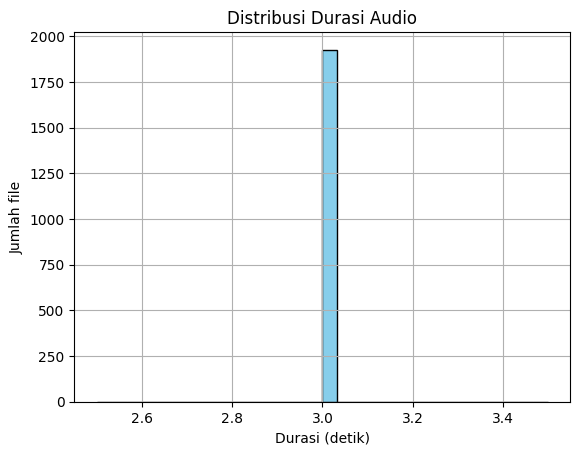

In [31]:
df = pd.read_csv('Metadata_Augmented.csv')
folder = 'File_submission_final'

print(f"Jumlah baris metadata: {len(train_df)}")

print("\nDistribusi kelas:")
print(train_df['Class'].value_counts())

# Cek format file di Train
wrong_format = [f for f in os.listdir(folder) if not f.endswith('.wav')]
print("\nFile dengan format salah:", wrong_format)

# Cek duplikat (FileName, Class)
dup_rows = train_df.duplicated(subset=['FileName', 'Class'])
print("Jumlah baris duplikat persis:", dup_rows.sum())

# Cek duplikat FileName saja di Train
fname_counts = df['FileName'].value_counts()
fname_dups = train_fname_counts[fname_counts > 1]
print("Jumlah FileName yang duplikat:", len(fname_dups))
if not fname_dups.empty:
    print(fname_dups)

# Cek durasi
train_durations = []
train_sr = []
train_files = []
train_errors = []

for fn in train_df['FileName']:
    path = os.path.join('File_submission_final', fn)
    try:
        y, sr = librosa.load(path, sr=None)
        train_durations.append(len(y) / sr)
        train_sr.append(sr)
        train_files.append(fn)
    except Exception as e:
        print(f"Error reading {fn} in Train: {e}")
        train_errors.append(fn)

print("\nJumlah file error:", len(train_errors))
print("Sample rate unik:", set(train_sr))
if train_durations:
    print("Durasi min  :", round(min(train_durations), 2), "detik")
    print("Durasi max  :", round(max(train_durations), 2), "detik")
    print("Durasi mean :", round(sum(train_durations)/len(train_durations), 2), "detik")

    plt.hist(train_durations, bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribusi Durasi Audio")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah file")
    plt.grid(True)
    plt.show()

# Visualisasi Data

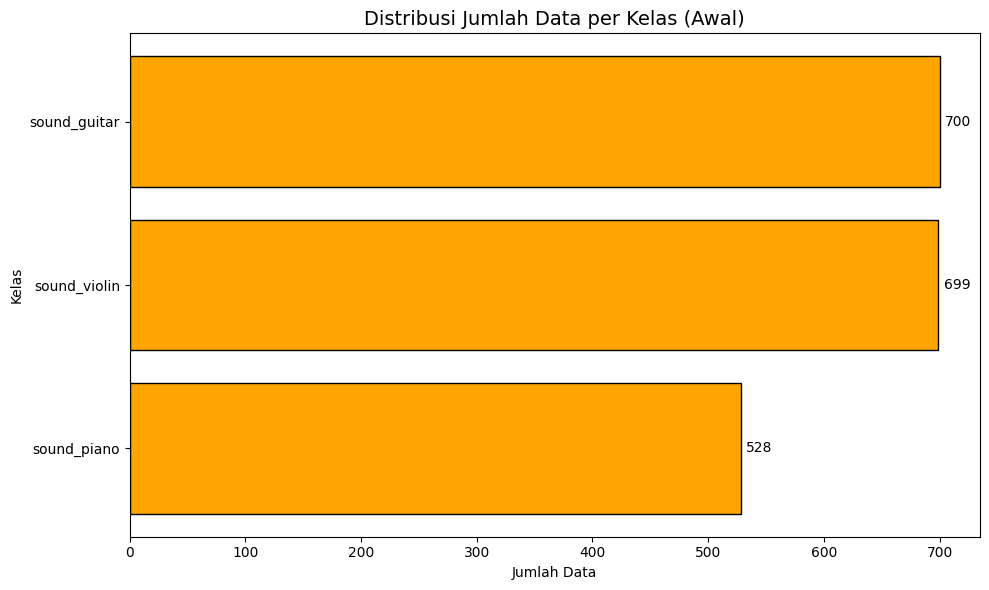

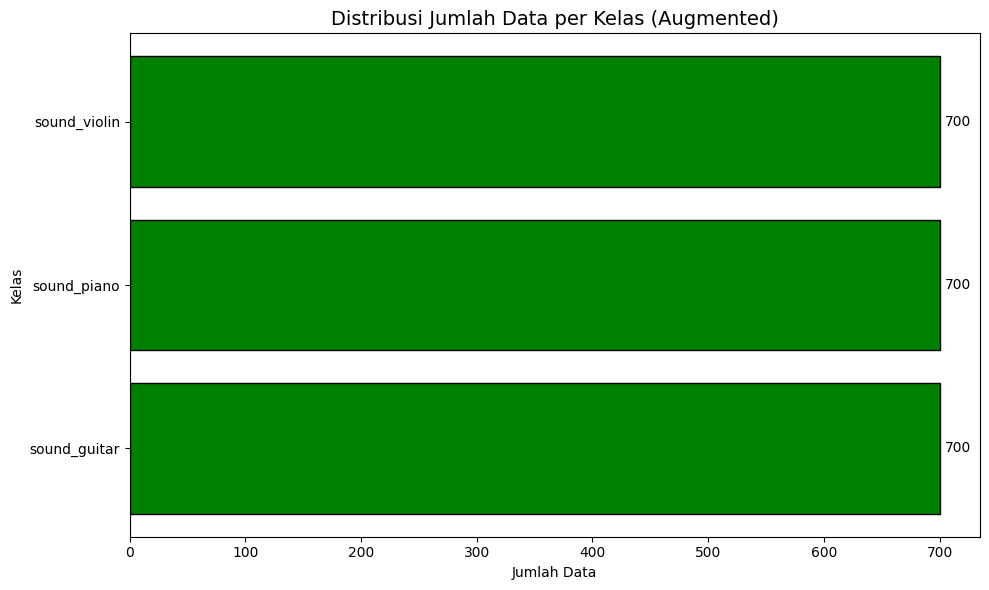

In [35]:
df = pd.read_csv('Metadata_Clean.csv')
final_df = pd.read_csv('Metadata_Augmented.csv') 

class_counts = df['Class'].value_counts().sort_values()
final_class_counts = final_df['Class'].value_counts().sort_values()

# Plot metadata CLEAN (sebelum augmentasi)
plt.figure(figsize=(10, 6))
bars = plt.barh(train_class_counts.index, train_class_counts.values,
                color='orange', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas (Awal)', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

# Plot metadata FINAL (sesudah augmentasi)
plt.figure(figsize=(10, 6))
bars = plt.barh(final_class_counts.index, final_class_counts.values,
                color='green', edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=10)

plt.title('Distribusi Jumlah Data per Kelas (Augmented)', fontsize=14)
plt.xlabel('Jumlah Data')
plt.ylabel('Kelas')
plt.tight_layout()
plt.show()

Cek File Anomali

In [36]:
AUDIO_DIR = 'File_submission_final'
EXPECTED_DURATION = 3.0  
SILENCE_THRESHOLD = 0.003
instrument = ''  

# Load metadata
df = pd.read_csv('Metadata_Clean.csv') 

# Filter hanya instrumen yang ingin diperiksa
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Untuk mencatat anomali
anomali_files = []

# Loop per file
for idx, row in filtered.iterrows():
    file_name = row['FileName']
    full_path = os.path.join(AUDIO_DIR, file_name)

    try:
        # Load file audio
        y, sr = librosa.load(full_path, sr=None)

        # Cek durasi
        duration = librosa.get_duration(y=y, sr=sr)
        if duration < EXPECTED_DURATION:
            anomali_files.append((file_name, "Durasi kurang"))

        # Cek apakah audio terlalu sunyi
        rms = np.sqrt(np.mean(y ** 2))
        if rms < SILENCE_THRESHOLD:
            anomali_files.append((file_name, "Terlalu sunyi / tidak ada suara"))

        # Cek apakah spektrum flat (noise atau file kosong)
        spec = np.abs(librosa.stft(y))
        spectral_flatness = librosa.feature.spectral_flatness(S=spec)
        if np.mean(spectral_flatness) > 1.0:  # flatness tinggi = noise / tidak ada pitch
            anomali_files.append((file_name, "Spektrum terlalu flat (mungkin noise)"))

    except Exception as e:
        anomali_files.append((file_name, f"Error saat dibaca: {str(e)}"))

# Tampilkan hasil
if anomali_files:
    print("Ditemukan file dengan potensi anomali:")
    for file, issue in anomali_files:
        print(f"- {file}: {issue}")
else:
    print("Semua file audio terlihat normal.")

Semua file audio terlihat normal.


Visualisasi waveform

In [298]:
def plot_waveform(data, sr, label):
    plt.figure(figsize=(10, 4))
    plt.title(f'Waveform: {label}', fontsize=16)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Fungsi untuk menampilkan spectrogram
def plot_spectrogram(data, sr, label):
    X = librosa.stft(data)
    X_db = librosa.amplitude_to_db(np.abs(X))

    plt.figure(figsize=(10, 4))
    plt.title(f'Spectrogram: {label}', fontsize=16)
    librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

File ditemukan: Train_submission_final\04-47367.wav


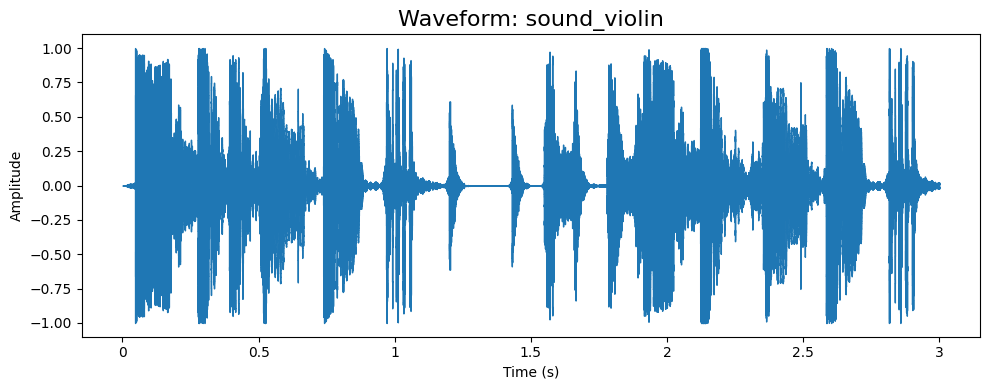

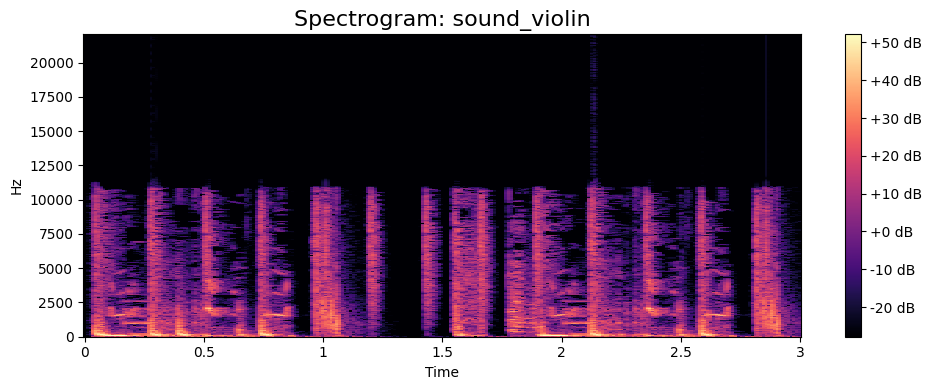

In [299]:
instrument = 'sound_violin'

# Cari baris yang cocok
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Cek apakah ditemukan
if not filtered.empty:
    file_path = filtered['FileName'].iloc[0]
    full_path = os.path.join('Train_submission_final', file_path)
    print("File ditemukan:", full_path)
    
    # LOAD audio di sini
    audio_data, sr = librosa.load(full_path, sr=None)

    # Plot
    plot_waveform(audio_data, sr, instrument)
    plot_spectrogram(audio_data, sr, instrument)
    
    display(Audio(audio_data, rate=sr))
else:
    print(f"Tidak ada file untuk instrumen: {instrument}")

File ditemukan: Train_submission_final\035568_upright-piano-71570.wav


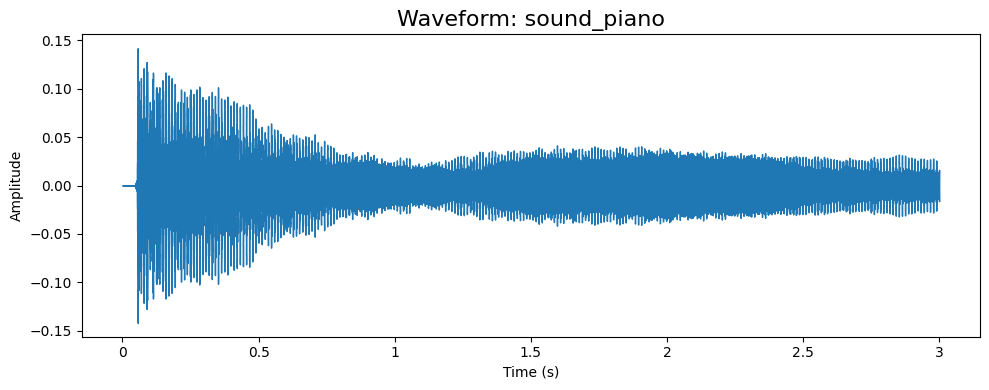

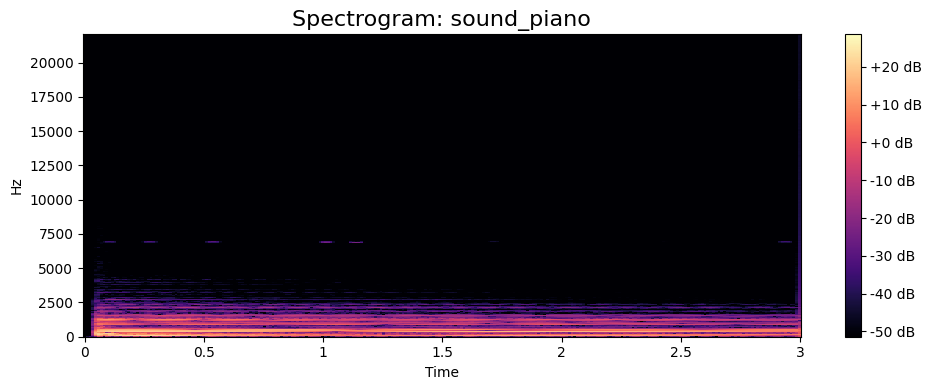

In [300]:
instrument = 'sound_piano'
target_file = '035568_upright-piano-71570.wav'

# Cari baris yang cocok
filtered = df[(df['Class'].str.lower() == instrument.lower()) & (df['FileName'] == target_file)]

# Cek apakah ditemukan
if not filtered.empty:
    file_path = filtered['FileName'].iloc[0]
    full_path = os.path.join('Train_submission_final', file_path)
    print("File ditemukan:", full_path)
    
    # LOAD audio di sini
    audio_data, sr = librosa.load(full_path, sr=None)

    # Plot
    plot_waveform(audio_data, sr, instrument)
    plot_spectrogram(audio_data, sr, instrument)
    
    display(Audio(audio_data, rate=sr))
else:
    print(f"Tidak ada file untuk instrumen: {instrument}")

File ditemukan: Train_submission\1-E1-Major 00.wav


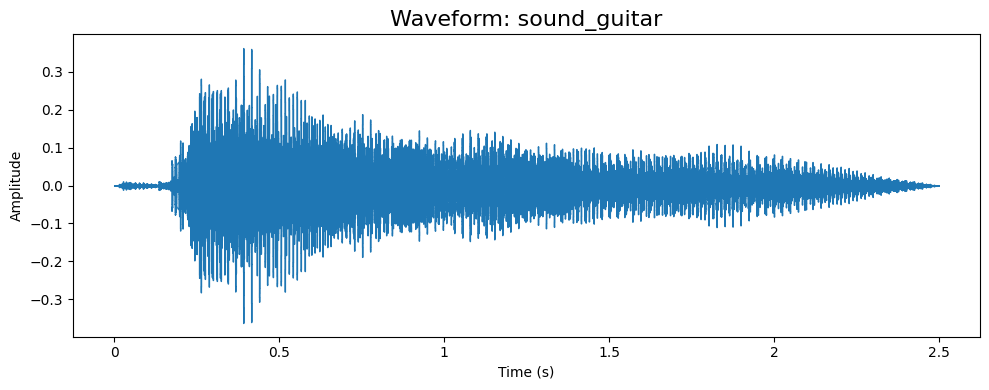

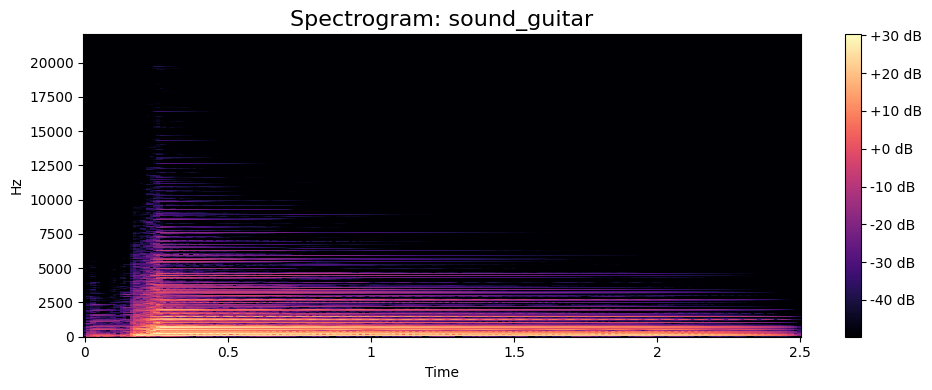

In [301]:
instrument = 'sound_guitar'

# Cari baris yang cocok
filtered = df[df['Class'].str.lower() == instrument.lower()]

# Cek apakah ditemukan
if not filtered.empty:
    file_path = filtered['FileName'].iloc[0]
    full_path = os.path.join('Train_submission', file_path)
    print("File ditemukan:", full_path)
    
    # LOAD audio di sini
    audio_data, sr = librosa.load(full_path, sr=None)

    # Plot
    plot_waveform(audio_data, sr, instrument)
    plot_spectrogram(audio_data, sr, instrument)
    
    display(Audio(audio_data, rate=sr))
else:
    print(f"Tidak ada file untuk instrumen: {instrument}")

# Framing & Windowing

In [37]:
def framing_windowing(signal, sample_rate=44100, frame_duration=0.025, hop_duration=0.01):
    frame_length = int(frame_duration * sample_rate)
    hop_length = int(hop_duration * sample_rate)

    # Jika sinyal terlalu pendek
    if len(signal) < frame_length:
        return np.array([])

    num_frames = 1 + int((len(signal) - frame_length) / hop_length)
    frames = np.zeros((num_frames, frame_length))
    window = hamming(frame_length, sym=False)
    
    for i in range(num_frames):
        start = i * hop_length
        frames[i] = signal[start:start + frame_length] * window
        
    return frames

INPUT_DIR = 'File_submission_final'
FRAME_DURATION = 0.025  # 25ms
HOP_DURATION = 0.01     # 10ms
OUTPUT_DIR = 'Framed_Features_NPZ'

os.makedirs(OUTPUT_DIR, exist_ok=True)

all_framed_data = {}

for file_name in os.listdir(INPUT_DIR):
    if file_name.endswith('.wav'):
        file_path = os.path.join(INPUT_DIR, file_name)
        try:
            y, sr = librosa.load(file_path, sr=44100)
            frames = framing_windowing(y, sample_rate=sr, frame_duration=FRAME_DURATION, hop_duration=HOP_DURATION)

            if frames.size > 0:
                all_framed_data[file_name] = frames
                npz_name = os.path.splitext(file_name)[0] + '.npz'
                np.savez_compressed(os.path.join(OUTPUT_DIR, npz_name),
                                    frames=frames, sr=sr)
                
                print(f"{file_name} → {frames.shape[0]} frame disimpan")
            else:
                print(f"{file_name} → sinyal terlalu pendek")

        except Exception as e:
            print(f"Gagal memproses {file_name}: {e}")

print("\nSemua hasil framing telah disimpan di folder:", OUTPUT_DIR)

035568_upright-piano-71570.wav → 298 frame disimpan
035568_upright-piano-71570_aug103_ps-2.wav → 298 frame disimpan
04-47367.wav → 298 frame disimpan
046578_tribal-drum-rhythms-03wav-68096.wav → 298 frame disimpan
054399_8039s-old-school-rap-drum-loop-80433.wav → 298 frame disimpan
056514_drum-40118.wav → 298 frame disimpan
059960_sonido2-sincopa-alta-7mp3-47316.wav → 298 frame disimpan
060311_rubbing-drum-sticksaif-82905.wav → 298 frame disimpan
065339_metal-bass-drum-90850.wav → 298 frame disimpan
066166_qui-c39est-qu39est-tombe-loop-t85wav-39366.wav → 298 frame disimpan
068320_hang-drum-2wav-80568.wav → 298 frame disimpan
1-E1-Major 00.wav → 298 frame disimpan
1-E1-Major 01.wav → 298 frame disimpan
1-E1-Major 02.wav → 298 frame disimpan
1-E1-Major 03.wav → 298 frame disimpan
1-E1-Major 04.wav → 298 frame disimpan
1-E1-Major 05.wav → 298 frame disimpan
1-E1-Major 06.wav → 298 frame disimpan
1-E1-Major 07.wav → 298 frame disimpan
1-E1-Major 08.wav → 298 frame disimpan
1-E1-Major 09.wa

Cek Hasil Framing

In [383]:
file_path = 'Framed_Features_NPZ/140-bpm-amen-break-original-processed-6945.npz'

data = np.load(file_path)

# Daftar key
print("Keys di dalam .npz:", data.files)

frames = data['frames']     
sr = data['sr']          

# Cek bentuk data
print("Shape frames:", frames.shape)
print("Sample rate:", sr)

# Lihat isi frame
df_frames = pd.DataFrame(frames)
print(df_frames.head())  

Keys di dalam .npz: ['frames', 'sr']
Shape frames: (298, 1102)
Sample rate: 44100
       0         1         2         3         4         5         6     \
0  0.002947  0.009015  0.011230  0.007001  0.001963  0.001016  0.002533   
1  0.015967  0.016357  0.012216  0.007445  0.004572  0.003313  0.003839   
2  0.009688 -0.000100 -0.005732  0.000506  0.010969  0.013408  0.006854   
3  0.014932  0.009662  0.006985  0.007577  0.007778  0.006933  0.008199   
4 -0.011707 -0.009686 -0.021937 -0.034375 -0.036236 -0.032556 -0.031811   

       7         8         9     ...      1092      1093      1094      1095  \
0  0.003250  0.003839  0.006332  ...  0.011291  0.014026  0.010868  0.006239   
1  0.007811  0.014446  0.018961  ...  0.010111  0.007948  0.009357  0.013183   
2 -0.000177 -0.002299 -0.000664  ... -0.074944 -0.075068 -0.073582 -0.072476   
3  0.012479  0.016438  0.016986  ... -0.051327 -0.050103 -0.053583 -0.054509   
4 -0.033159 -0.032962 -0.033169  ...  0.012092  0.003008  0.000084 

# Ekstraksi Fitur

In [566]:
def apply_hamming_window(frame):
    hamming_window = hamming(len(frame))
    return frame * hamming_window
    
def load_npz_file(npz_path):
    data = np.load(npz_path)
    frames = data['frames']
    sr = int(data['sr'])
    return frames, {'sr': sr}

Zero Crossing Rate (ZCR)

In [567]:
def calculate_zcr(frame):
    # Menghitung tanda dari setiap sampel
    signs = np.sign(frame)
    # Menghitung perubahan tanda
    sign_changes = np.diff(signs)
    # Menghitung jumlah zero crossing
    if len(frame) > 1:
        zcr = np.sum(np.abs(sign_changes)) / (2 * (len(frame) - 1))
    else:
        zcr = 0
    return zcr

RMS Energy

In [568]:
def calculate_rms(frame):
    if len(frame) > 0:
        rms = np.sqrt(np.mean(frame**2))
    else:
        rms = 0
    return rms

Spectral Centroid

In [580]:
def calculate_spectral_centroid(frame, sr=44100):
    # Konversi ke domain frekuensi menggunakan FFT
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    
    # Membuat array frekuensi
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    # Menghitung spectral centroid
    if np.sum(magnitude) > 0:
        spectral_centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
    else:
        spectral_centroid = 0
        
    return spectral_centroid

Spectral Spread 

In [581]:
def calculate_spectral_spread(frame, sr=44100):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    power_spectrum = magnitude ** 2
    
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    centroid = np.sum(freqs * power_spectrum) / (np.sum(power_spectrum) + 1e-10)
    
    spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * power_spectrum) / (np.sum(power_spectrum) + 1e-10))
    
    return spread

Spectral Roll-off

In [582]:
def calculate_spectral_rolloff(frame, sr=44100, roll_percent=0.85):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    power_spectrum = magnitude ** 2
    
    freqs = np.fft.rfftfreq(len(frame), 1/sr)
    
    cumulative_power = np.cumsum(power_spectrum)
    total_power = cumulative_power[-1]
    threshold = roll_percent * total_power
    
    idx = np.where(cumulative_power >= threshold)[0]
    if len(idx) > 0:
        rolloff_freq = freqs[idx[0]]
    else:
        rolloff_freq = freqs[-1]
    return rolloff_freq

In [583]:
def extract_features_per_frame(frame, sr=44100):
    frame = apply_hamming_window(frame)
    
    # Ekstraksi fitur
    zcr = calculate_zcr(frame)
    rms = calculate_rms(frame)
    spectral_centroid = calculate_spectral_centroid(frame, sr)
    spread = calculate_spectral_spread(frame, sr)
    rolloff = calculate_spectral_rolloff(frame, sr)
    
    return {
        'zcr': zcr,
        'rms': rms,
        'spectral_centroid': spectral_centroid,
        'spectral_spread': spread,
        'spectral_rolloff': rolloff,
    }

In [584]:
def process_npz_dataset(metadata_path, npz_dir, output_csv=None, sr=44100):
    metadata = pd.read_csv(metadata_path)
    results = []
    
    # Loop setiap baris di metadata
    for idx, row in metadata.iterrows():
        filename = row['FileName'] 
        
        base_name = os.path.splitext(filename)[0]
        npz_filename = base_name + '.npz'
        npz_path = os.path.join(npz_dir, npz_filename)
        
        try:
            # Load file NPZ
            frames, npz_metadata = load_npz_file(npz_path)
            
            if frames is None:
                print(f"Could not load frames from {npz_filename}")
                continue
            
            features_list = []
            
            # Ekstrak fitur untuk setiap frame
            for frame_idx, frame in enumerate(frames):
                # Pastikan frame adalah 1D array
                if frame.ndim > 1:
                    frame = frame.flatten()
                
                features = extract_features_per_frame(frame, sr)
                features_list.append(features)
            
            # Hitung statistik dari semua frame
            if features_list:
                df_features = pd.DataFrame(features_list)
                stats = {
                    'FileName': filename,
                    'num_frames': len(frames),

                    # ZCR
                    'zcr_mean': df_features['zcr'].mean(),
                    'zcr_std': df_features['zcr'].std(),

                    # RMS
                    'rms_mean': df_features['rms'].mean(),
                    'rms_std': df_features['rms'].std(),

                    # Spectral Centroid
                    'spectral_centroid_mean': df_features['spectral_centroid'].mean(),
                    'spectral_centroid_std': df_features['spectral_centroid'].std(),

                    # Spectral Spread
                    'spectral_spread_mean': df_features['spectral_spread'].mean(),
                    'spectral_spread_std': df_features['spectral_spread'].std(),

                    # Spectral Roll-Off
                    'spectral_rolloff_mean': df_features['spectral_rolloff'].mean(),
                    'spectral_rolloff_std': df_features['spectral_rolloff'].std(),
                }
                
                # Gabungkan dengan metadata asli
                for col in row.index:
                    if col != 'FileName':  # Hindari duplikat filename
                        stats[col] = row[col]
                
                results.append(stats)
            
        except Exception as e:
            print(f"Error processing {npz_filename}: {str(e)}")
            continue
    
    # Buat DataFrame hasil
    if results:
        result_df = pd.DataFrame(results)
        
        if output_csv:
            result_df.to_csv(output_csv, index=False)
            print(f"Semua hasil telah disimpan di folder: {output_csv}")
        
        return result_df
    else:
        print("No files were successfully processed!")
        return pd.DataFrame()

process_npz_dataset(
    metadata_path='Metadata_Augmented.csv',
    npz_dir='Framed_Features_NPZ',
    output_csv='fitur_ekstraksi.csv',
    sr=44100
)

Semua hasil telah disimpan di folder: fitur_ekstraksi.csv


,FileName,num_frames,zcr_mean,zcr_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_spread_mean,spectral_spread_std,spectral_rolloff_mean,spectral_rolloff_std,Class
0,1-E1-Major 00.wav,298,0.014203,0.007548,0.019303,0.015585,570.330613,355.599129,214.447835,116.288269,381.918172,204.527533,sound_guitar
1,1-E1-Major 01.wav,298,0.013773,0.009596,0.028927,0.027728,699.596194,886.941439,263.987420,389.916037,379.903836,303.176972,sound_guitar
2,1-E1-Major 02.wav,298,0.017103,0.011700,0.029819,0.028273,821.281617,982.397911,336.813098,392.094614,412.133217,228.774860,sound_guitar
3,1-E1-Major 03.wav,298,0.014464,0.007901,0.024090,0.021107,604.414459,453.842183,212.477476,164.902482,355.866089,198.271059,sound_guitar
4,1-E1-Major 04.wav,298,0.015931,0.008978,0.026609,0.024564,653.238676,418.554132,246.200379,147.357843,400.584355,221.500587,sound_guitar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,WaveDrum02_45SD (96).wav,298,0.088140,0.027024,0.003599,0.008135,4343.294941,1059.159688,2057.448659,792.596533,1972.169576,1626.536934,sound_violin
2096,WaveDrum02_45SD (97).wav,298,0.031251,0.023881,0.002531,0.013085,3086.535721,1793.266291,1148.689861,786.434756,647.944859,668.350555,sound_violin
2097,WaveDrum02_45SD (98).wav,298,0.270596,0.263380,0.002942,0.008467,8541.518235,5218.893855,4395.084348,3096.979137,8494.993544,9833.095382,sound_violin
2098,WaveDrum02_45SD (99).wav,298,0.072649,0.023190,0.005912,0.011319,3556.033783,444.199085,1563.513789,403.901982,1723.869048,1271.926447,sound_violin


In [586]:
from scipy.fftpack import dct

metadata_train = pd.read_csv("Metadata_Augmented.csv")  
npz_folder = "Framed_Features_NPZ"

mfcc_list = []

for _, row in metadata_train.iterrows():
    filename = row['FileName'].replace('.wav', '.npz')
    label = row['Class']
    file_path = os.path.join(npz_folder, filename)

    try:
        # Set Parameter
        data = np.load(file_path)
        frames = data['frames']
        sr = int(data['sr'])
        n_fft = 2048
        n_mfcc = 13  

        if frames.shape[0] == 0:
            print(f"{filename} kosong → dilewati")
            continue
            
        if frames.shape[1] != n_fft:
            pad_width = max(0, n_fft - frames.shape[1])
            frames = np.pad(frames[:, :n_fft], ((0, 0), (0, pad_width)), mode='constant')

        # FFT Setiap Frame
        fft_frames = np.fft.rfft(frames, axis=1)
        power_spectrum = np.abs(fft_frames) ** 2
        log_power_spectrum = np.log10(power_spectrum + 1e-10)

        # Filterbank Mel
        mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mfcc)
        mel_spec = np.dot(power_spectrum, mel_filter.T)
        log_mel_spec = np.log(mel_spec + 1e-10)

        # DCT → MFCC
        mfcc = dct(log_mel_spec, type=2, axis=1, norm='ortho')[:, :n_mfcc]
        mfcc_mean = np.mean(mfcc, axis=0)
        mfcc_std = np.std(mfcc, axis=0)

        # Simpan list
        row_data = [filename] + mfcc_mean.tolist() + mfcc_std.tolist() + [label]
        mfcc_list.append(row_data)
    
    except Exception as e:
        print(f"Gagal memproses {filename}: {e}")

# Simpan ke file CSV
mfcc_columns = ['FileName'] + [f'MFCC_Mean_{i+1}' for i in range(n_mfcc)] + [f'MFCC_Std_{i+1}' for i in range(n_mfcc)] + ['Class']

df_train_mfcc = pd.DataFrame(mfcc_list, columns=mfcc_columns)
df_train_mfcc.to_csv("fitur_ekstraksi_mfcc.csv", index=False)

print(f"\nProses selesai MFCC disimpan di: {df_train_mfcc}")


Proses selesai MFCC disimpan di:                            FileName  MFCC_Mean_1  MFCC_Mean_2  MFCC_Mean_3  \
0                 1-E1-Major 00.npz   -39.284717    15.644383     0.418043   
1                 1-E1-Major 01.npz   -38.023906    15.346034     0.333696   
2                 1-E1-Major 02.npz   -36.690272    15.310236    -0.656118   
3                 1-E1-Major 03.npz   -38.259291    15.221868     0.051649   
4                 1-E1-Major 04.npz   -37.239832    15.376122    -0.273933   
...                             ...          ...          ...          ...   
2095       WaveDrum02_45SD (96).npz   -35.222543     7.909631    -0.804103   
2096       WaveDrum02_45SD (97).npz   -57.312276     7.348482     0.565615   
2097       WaveDrum02_45SD (98).npz   -49.378316     7.394123     1.836694   
2098       WaveDrum02_45SD (99).npz   -29.102290     8.423479    -1.381906   
2099  DRUM_SOUND (20)_aug0_ps-2.npz   -38.257556     5.739453     0.247686   

      MFCC_Mean_4  MFCC_Mean_

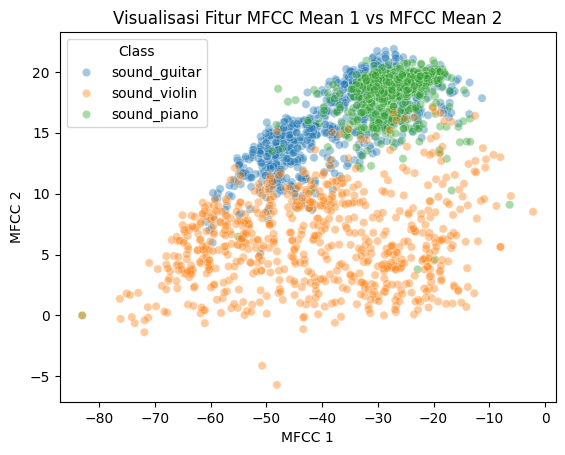

In [3]:
df = pd.read_csv("fitur_ekstraksi_mfcc.csv")

# Ambil 2 fitur MFCC untuk scatterplot
X = df[['MFCC_Mean_1', 'MFCC_Mean_2']]
y = df['Class']

# Visualisasi
sns.scatterplot(x=X['MFCC_Mean_1'],
                y=X['MFCC_Mean_2'],
                hue=y,
                hue_order=["sound_guitar", "sound_violin", "sound_piano"],
                alpha=0.4)

plt.title("Visualisasi Fitur MFCC Mean 1 vs MFCC Mean 2")
plt.xlabel("MFCC 1")
plt.ylabel("MFCC 2")
plt.show()

In [588]:
df_fitur = pd.read_csv("fitur_ekstraksi.csv")
df_mfcc  = pd.read_csv("fitur_ekstraksi_mfcc.csv")

# Hapus ekstensi di kedua dataframe
df_fitur['FileName'] = df_fitur['FileName'].str.replace('.wav', '', regex=False)
df_mfcc['FileName']  = df_mfcc['FileName'].str.replace('.npz', '', regex=False)
df_gabung = pd.merge(df_fitur, df_mfcc, on=['FileName', 'Class'])

# Cek hasil kolom gabungan
print(df_gabung.columns.tolist())

# Urutkan kolom
cols = (['FileName'] + 
        [col for col in df_gabung.columns if col not in ['FileName', 'Class']] + 
        ['Class'])
df_gabung = df_gabung[cols]

# Simpan hasil gabungan
df_gabung.to_csv("fitur_ekstraksi_gabungan.csv", index=False)
print("Berhasil digabung")

['FileName', 'num_frames', 'zcr_mean', 'zcr_std', 'rms_mean', 'rms_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_spread_mean', 'spectral_spread_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'Class', 'MFCC_Mean_1', 'MFCC_Mean_2', 'MFCC_Mean_3', 'MFCC_Mean_4', 'MFCC_Mean_5', 'MFCC_Mean_6', 'MFCC_Mean_7', 'MFCC_Mean_8', 'MFCC_Mean_9', 'MFCC_Mean_10', 'MFCC_Mean_11', 'MFCC_Mean_12', 'MFCC_Mean_13', 'MFCC_Std_1', 'MFCC_Std_2', 'MFCC_Std_3', 'MFCC_Std_4', 'MFCC_Std_5', 'MFCC_Std_6', 'MFCC_Std_7', 'MFCC_Std_8', 'MFCC_Std_9', 'MFCC_Std_10', 'MFCC_Std_11', 'MFCC_Std_12', 'MFCC_Std_13']
Berhasil digabung


In [590]:
df_gabung = pd.read_csv("fitur_ekstraksi_gabungan.csv")
df_gabung.head()

,FileName,num_frames,zcr_mean,zcr_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_spread_mean,spectral_spread_std,...,MFCC_Std_5,MFCC_Std_6,MFCC_Std_7,MFCC_Std_8,MFCC_Std_9,MFCC_Std_10,MFCC_Std_11,MFCC_Std_12,MFCC_Std_13,Class
0,1-E1-Major 00,298,0.014203,0.007548,0.019303,0.015585,570.330613,355.599129,214.447835,116.288269,...,0.566540,0.517515,0.390596,0.344214,0.232847,0.230371,0.218120,0.234856,0.343526,sound_guitar
1,1-E1-Major 01,298,0.013773,0.009596,0.028927,0.027728,699.596194,886.941439,263.987420,389.916037,...,0.620139,0.476152,0.293712,0.269450,0.230451,0.187279,0.178858,0.213004,0.304632,sound_guitar
2,1-E1-Major 02,298,0.017103,0.011700,0.029819,0.028273,821.281617,982.397911,336.813098,392.094614,...,0.681959,0.666244,0.355195,0.354541,0.226984,0.290826,0.197805,0.172041,0.224349,sound_guitar
3,1-E1-Major 03,298,0.014464,0.007901,0.024090,0.021107,604.414459,453.842183,212.477476,164.902482,...,0.866116,0.634586,0.364015,0.337140,0.326697,0.268414,0.265372,0.183033,0.283908,sound_guitar
4,1-E1-Major 04,298,0.015931,0.008978,0.026609,0.024564,653.238676,418.554132,246.200379,147.357843,...,0.791649,0.643256,0.334182,0.437014,0.286762,0.239963,0.268468,0.220766,0.239517,sound_guitar


# Reduksi (Chi-Square)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

df = pd.read_csv("fitur_ekstraksi_gabungan.csv")

X = df.drop(columns=['FileName', 'num_frames', 'Class'])
y = df['Class']

# Scaling agar fitur non-negatif
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reduksi Dimensi dengan Chi-Square
k = 10  # jumlah fitur terbaik yang dipilih
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Tampilkan informasi reduksi
print("Jumlah dimensi awal:", X.shape[1])
print("Jumlah dimensi setelah chi-square:", X_selected.shape[1])

selected_features = X.columns[selector.get_support()]
print("Fitur terpilih (Top-k chi-square):")
print(selected_features.tolist())

# Simpan hasil seleksi fitur
selected_feature_names = X.columns[selector.get_support()]
df_selected = pd.DataFrame(X_selected, columns=selected_feature_names)
df_selected['Class'] = y.values
df_selected.to_csv("metadata_chi-square.csv", index=False)

print("\nHasil chi-square berhasil disimpan ke 'metadata_chi-square.csv'")

Jumlah dimensi awal: 36
Jumlah dimensi setelah chi-square: 10
Fitur terpilih (Top-k chi-square):
['zcr_mean', 'zcr_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_spread_mean', 'spectral_spread_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'MFCC_Mean_2', 'MFCC_Std_1']

Hasil chi-square berhasil disimpan ke 'metadata_chi-square.csv'


# Split Data

In [38]:
from sklearn.model_selection import train_test_split

# Load data hasil seleksi chi2
df = pd.read_csv("metadata_chi-square.csv")

# Pisahkan fitur dan label
X = df.drop(columns=["Class"])
y = df["Class"]

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Simpan hasil split ke file CSV
train_split_df = X_train.copy()
train_split_df["Class"] = y_train.values
train_split_df.to_csv("train_chisquare.csv", index=False)

test_split_df = X_test.copy()
test_split_df["Class"] = y_test.values
test_split_df.to_csv("test_chisquare.csv", index=False)

# Info
print("Data berhasil di-split:")
print("Jumlah data training:", len(X_train))
print("Jumlah data testing:", len(X_test))

# Cek distribusi label
print("\nDistribusi Kelas di Data Training:")
print(y_train.value_counts())
print("Distribusi Kelas di Data Testing:")
print(y_test.value_counts())

print("\nFile tersimpan: 'train_chisquare.csv' dan 'test_chisquare.csv'")

Data berhasil di-split:
Jumlah data training: 1680
Jumlah data testing: 420

Distribusi Kelas di Data Training:
Class
sound_piano     560
sound_violin    560
sound_guitar    560
Name: count, dtype: int64
Distribusi Kelas di Data Testing:
Class
sound_piano     140
sound_guitar    140
sound_violin    140
Name: count, dtype: int64

File tersimpan: 'train_chisquare.csv' dan 'test_chisquare.csv'


# Model SVM

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import joblib

df_train = pd.read_csv("train_chisquare.csv")
X_train = df_train.drop(columns=["Class"])
y_train = df_train["Class"]

# Parameter SVM
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale"],
    "kernel": ["rbf"]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training dengan GridSearchCV
svm = SVC(class_weight='balanced', probability=True, random_state=42)
grid = GridSearchCV(svm, param_grid=param_grid, cv=cv_strategy, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Hasil CV training
print("\n=== Hasil GridSearch (Training) ===")
print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# --- Simpan model ---
joblib.dump(grid, "svm_split_chi2_model.joblib")
print("\nModel disimpan ke: svm_split_chi2_model.joblib")

Fitting 5 folds for each of 3 candidates, totalling 15 fits

=== Hasil GridSearch (Training) ===
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9119047619047619

Model disimpan ke: svm_split_chi2_model.joblib



=== Evaluasi Model ===
              precision    recall  f1-score   support

sound_guitar       0.88      0.87      0.88       140
 sound_piano       0.90      0.89      0.90       140
sound_violin       0.92      0.94      0.93       140

    accuracy                           0.90       420
   macro avg       0.90      0.90      0.90       420
weighted avg       0.90      0.90      0.90       420



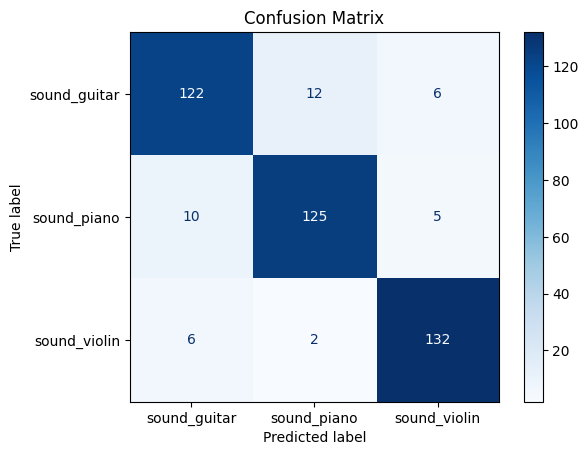

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data
df_test = pd.read_csv("test_chisquare.csv")
X_test = df_test.drop(columns=["Class"])
y_test = df_test["Class"]

# Load model hasil training
model = joblib.load("svm_split_chi2_model.joblib")

# Evaluasi
y_pred = model.predict(X_test)

print("\n=== Evaluasi Model ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()